In [119]:
# Import package of functions 
from function2 import *

## **I. Data Extraction and Data Visualization :**

**In this part we load the data. We also verify if it's clean, we visualize the data before adding some features**

As explained in the presentation of the project, we do the data processing part (I.), the modelling of gains (II.) and modelling of volatility (III.) with Bitcoin crypto data. After we determined a suitable model for Bitcoin, we will apply these models to other cryptocurrencies to build our efficient frontier (IV.)

##  **I.1 Scraping data using the Binance API**

We extract data from the API, taking the equivalent of two years. As for the interval, we take data at a daily interval. 

When we will have determined the suitable model for both expected gains (II.) and volatility (III.), we will use hourly data.

In [41]:
# Extraction parameters
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1DAY # daily interval
start_date = '2023-01-01'
end_date = '2024-12-01'

# Extract data from the API
df = fetch_binance_data_full(symbol, interval, start_date, end_date)

* Cleaning

In [42]:
# Convert 'timestamp' variable to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Inspect data
print(df.head())
print(df.info())

   timestamp      open      high       low     close        volume
0 2023-01-01  16541.77  16628.00  16499.01  16616.75   96925.41374
1 2023-01-02  16617.17  16799.23  16548.70  16672.87  121888.57191
2 2023-01-03  16672.78  16778.40  16605.28  16675.18  159541.53733
3 2023-01-04  16675.65  16991.87  16652.66  16850.36  220362.18862
4 2023-01-05  16850.36  16879.82  16753.00  16831.85  163473.56641
<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  700 non-null    datetime64[ns]
 1   open       700 non-null    float64       
 2   high       700 non-null    float64       
 3   low        700 non-null    float64       
 4   close      700 non-null    float64       
 5   volume     700 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 38.3 KB
None


- Verifying the presence of missing (NaN) values in the dataset

In [43]:
df.isna().sum() # No NAs in the dataset

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

Small dictionary of variables so far : 

* timestamp : our date variable (daily)
* open : opening price of the day 
* high : highest price of the day
* low : lowest ------------------
* close : closing ---------------
* volume : quantity of trades done in the day

* Simple display of closing price


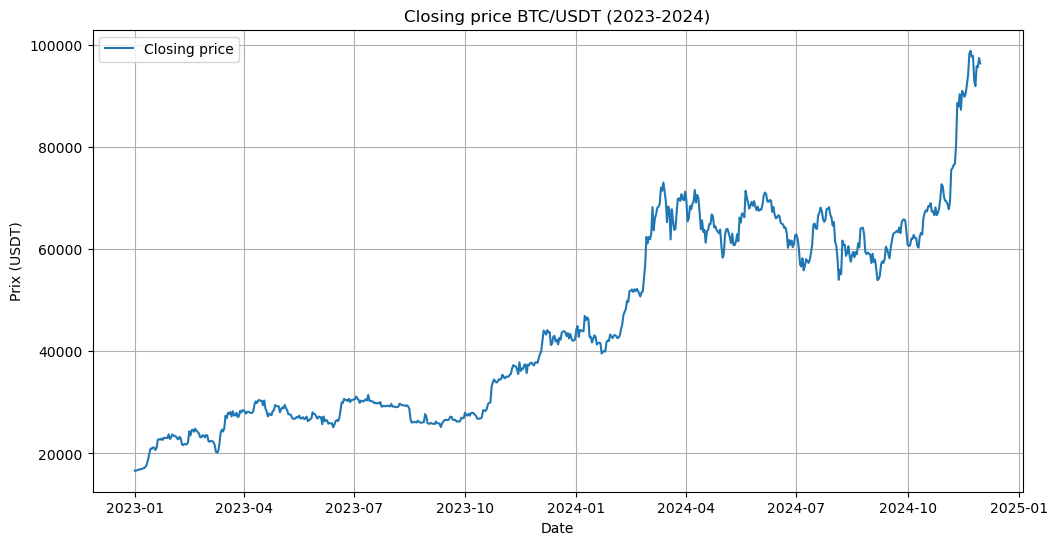

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['close'], label='Closing price')
plt.title("Closing price BTC/USDT (2023-2024)")
plt.xlabel("Date")
plt.ylabel("Prix (USDT)")
plt.legend()
plt.grid()
plt.show()

**Graph**: This graph shows a strong upward trend in BTC/USDT prices from 2023 to late 2024, with increased volatility toward the end. The sharp rise indicates bullish market sentiment, while the final dip suggests a potential correction.

We also see an plateau before 2024-10, which corresponds to the run-up to the US elections, and then a steep increase right after. This confirms our motivation to study the Bitcoin that seems impacted by the US elections.  

## **I.2 Enriching the dataset with additional variables and preprocessing it for modeling**


Enriching the database by adding indicators:

- Relative Strength Index (**RSI**): Measures the speed and magnitude of price movements (momentum).
- Exponential Moving Average (**EMA**): A weighted moving average that prioritizes recent prices, useful for identifying trends.
- Average True Range (**ATR**): Measures market volatility.

These indicators are calculated over the last 14 days, for a given timestamp.

More specifically, these variables will be used for our linear regression models, SVM and Neural networks (LSTM). For our ARMA Model, we only use the outcome variable.


In [45]:
final_data = append_technical_indicators(df)
final_data

,timestamp,open,high,low,close,volume,RSI,EMA,ATR
0,2023-01-14,19930.01,21258.00,19888.05,20954.92,393913.74951,99.633998,18092.438235,495.185000
1,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,97.301269,18462.979804,495.509643
2,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,97.535299,18826.002497,521.728240
3,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,96.083143,19133.843497,542.043366
4,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,83.971533,19339.660364,592.100982
...,...,...,...,...,...,...,...,...,...
682,2024-11-26,93010.01,94973.37,90791.10,91965.16,57858.73138,61.503602,91876.629955,3579.197691
683,2024-11-27,91965.16,97208.21,91792.14,95863.11,41153.42734,66.866856,92408.160628,3710.402856
684,2024-11-28,95863.11,96564.00,94640.00,95643.98,28814.54357,66.307586,92839.603211,3582.802652
685,2024-11-29,95643.99,98619.99,95364.99,97460.00,27701.78231,68.647934,93455.656116,3559.388177


- To prepare for modelling, the data is normalised using the MinMax scaler.

In [46]:
scaled_data = apply_minmax_scaler(final_data)
scaled_data

,timestamp,open,high,low,close,volume,RSI,EMA,ATR
0,2023-01-14,0.004759,0.021351,0.004235,0.017564,0.558635,1.000000,0.000000,0.000000
1,2023-01-15,0.017537,0.018761,0.012518,0.016522,0.247428,0.971200,0.004891,0.000091
2,2023-01-16,0.016541,0.024050,0.013273,0.020447,0.412930,0.974090,0.009683,0.007468
3,2023-01-17,0.020447,0.026217,0.016145,0.019812,0.387397,0.956161,0.013747,0.013184
4,2023-01-18,0.019780,0.026249,0.010721,0.014098,0.496505,0.806633,0.016463,0.027267
...,...,...,...,...,...,...,...,...,...
682,2024-11-26,0.917815,0.942345,0.890092,0.904761,0.073043,0.529246,0.973961,0.867691
683,2024-11-27,0.904761,0.970267,0.902599,0.953461,0.048905,0.595460,0.980977,0.904606
684,2024-11-28,0.953461,0.962218,0.938180,0.950724,0.031075,0.588555,0.986672,0.868705
685,2024-11-29,0.950724,0.987906,0.947238,0.973413,0.029467,0.617449,0.994804,0.862117


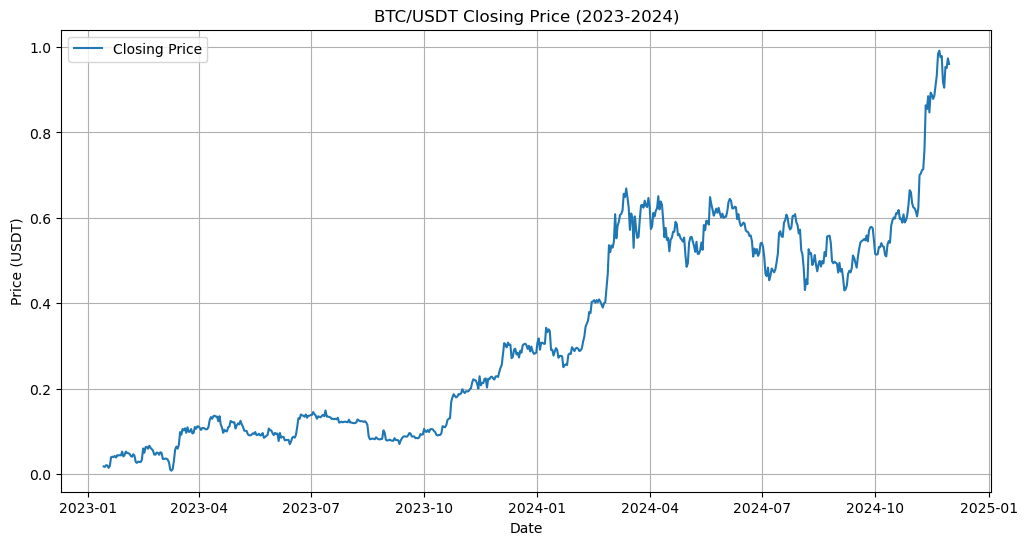

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(scaled_data['timestamp'], scaled_data['close'], label='Closing Price')
plt.title("BTC/USDT Closing Price (2023-2024)")
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.legend()
plt.grid()
plt.show()

We can see the newly scaled data, now constrained between 0 and 1.

Scaling the data is important for machine learning models because it ensures that all features have the same range, preventing features with larger values from dominating the training process. Indeed, machine learning models like neural networks are sensitive to the scale of input data and converge faster when the data is normalized.

## **I.3 Preparing data for ARMA modeling**

For linear time-series models, we need stationary series to work with. Since we will try our ARMA model in both daily and hourly data intervals, we need to find out if daily series and hourly series are stationary or not, and if not, do some transformations on the series to stationarise them (first differencing, log transformation)

For the whole ARMA part (here I.3 and II.1), we don't use scaled data (scaled_data), we use the raw series (df). 

* I.3.a Daily raw series: is it stationary? Visual inspection

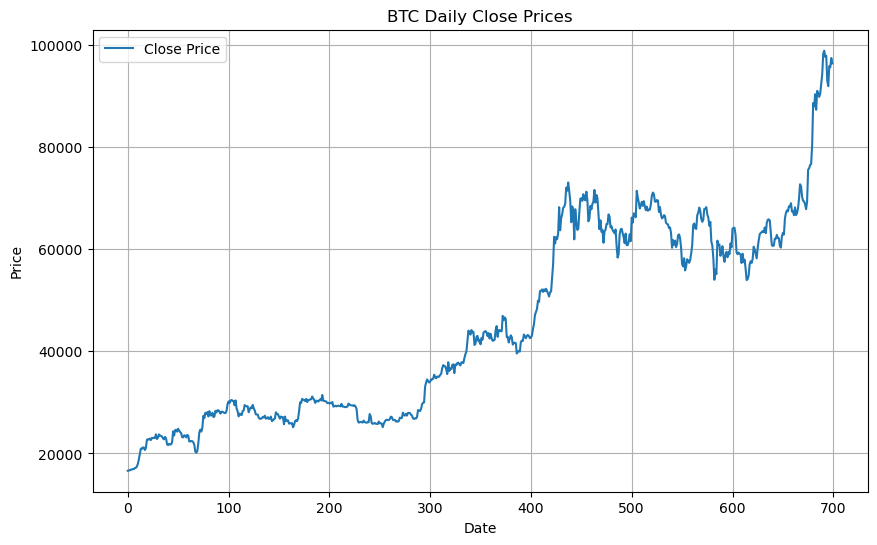

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Close Price')
plt.title('BTC Daily Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

The series does not seem to be stationary: we apply a transformation.

* I.3.b Log transformation

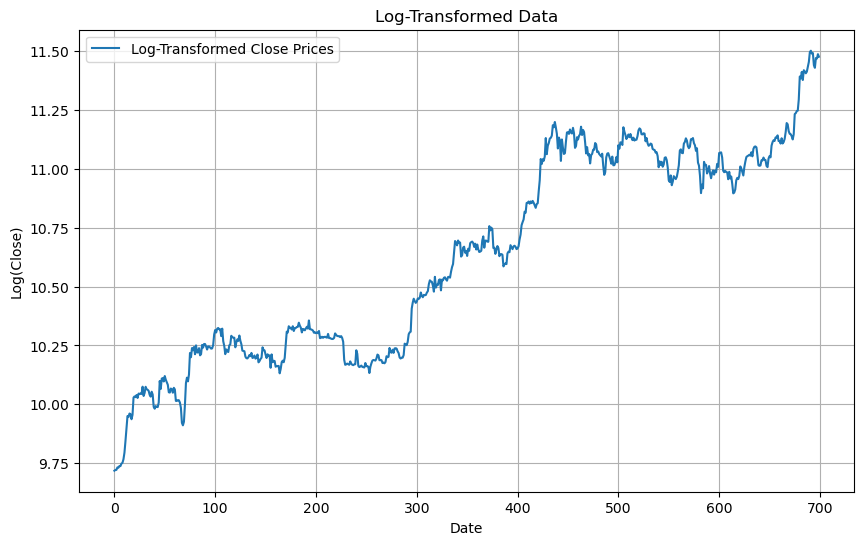

In [49]:
#Apply log transformation to the 'close' column
df['log_close'] = np.log(df['close'])

# Plot the transformed data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['log_close'], label='Log-Transformed Close Prices')
plt.title('Log-Transformed Data')
plt.xlabel('Date')
plt.ylabel('Log(Close)')
plt.legend()
plt.grid()
plt.show()

Log transformation – does not result in a stationary series. We try with first differencing.

* I.3.c First differencing

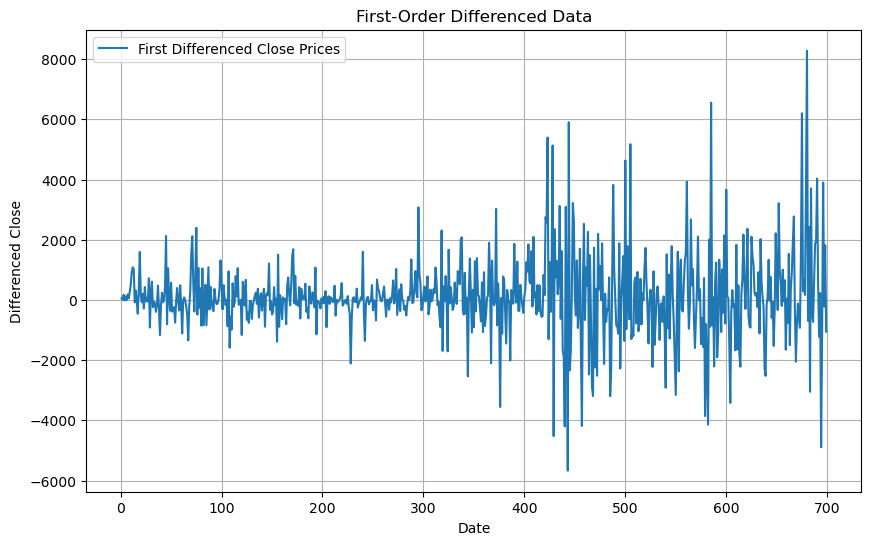

In [50]:
# Apply first-order differencing
df['close_diff'] = df['close'].diff()

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close_diff'], label='First Differenced Close Prices')
plt.title('First-Order Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close')
plt.legend()
plt.grid()
plt.show()

The series is still not stationary: the mean appears constant, but the variance is not (we observe heteroskedasticity, with the magnitude of the series increasing over time), and autocorrelation seems positive (values depend on their past values).

We attempt higher-order differencing.

* I.3.d Differencing of order 2

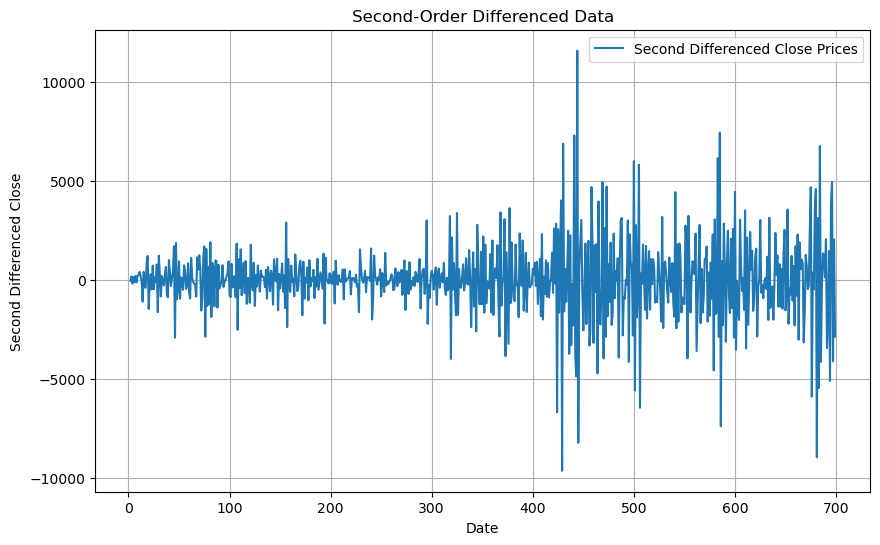

In [51]:
# differencing of order 2 

df['close_diff2'] = df['close_diff'].diff()

# Plot second-order differenced data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close_diff2'], label='Second Differenced Close Prices')
plt.title('Second-Order Differenced Data')
plt.xlabel('Date')
plt.ylabel('Second Differenced Close')
plt.legend()
plt.grid()
plt.show()

Again, not yet stationary. We should try log-differencing.

* I.3.e Log-Differencing

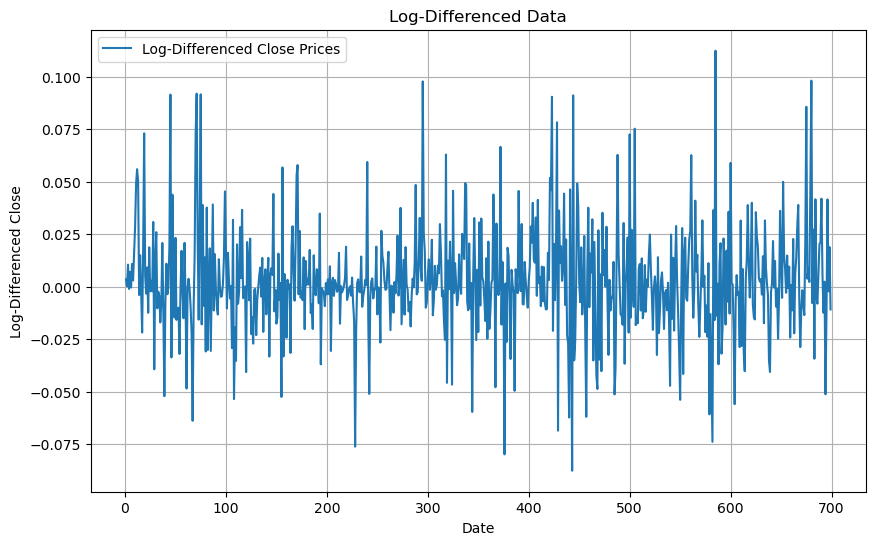

In [52]:
# Apply log transformation followed by differencing
df['log_close_diff'] = np.log(df['close']).diff()

# Plot the log-differenced data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['log_close_diff'], label='Log-Differenced Close Prices')
plt.title('Log-Differenced Data')
plt.xlabel('Date')
plt.ylabel('Log-Differenced Close')
plt.legend()
plt.grid()
plt.show()

The first-order differenced log transformation appears to be stationary. We will perform stationarity tests to confirm this in our ARMA modelling part (III.1).

We need to clean the timestamp, since we did our log-difference 

In [53]:
df.isna().sum() # NAs in the dataset

timestamp         0
open              0
high              0
low               0
close             0
volume            0
log_close         0
close_diff        1
close_diff2       2
log_close_diff    1
dtype: int64

In [61]:
data_cleaned = df.dropna(subset=['log_close_diff', 'timestamp'])

Since we will need the date variable to be numerical in order to conduct regression (sm.OLS does not support datetime objects), we normalise the variable as well

In [62]:
data_cleaned['timestamp'] = (data_cleaned['timestamp'] - data_cleaned['timestamp'].min()).dt.days

/tmp/ipykernel_1245/2068920397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['timestamp'] = (data_cleaned['timestamp'] - data_cleaned['timestamp'].min()).dt.days


Now that we have cleaned data for ARMA modelling (data_cleaned) and for other econometric/machine learning models (scaled_data), we can proceed to an attempt to forecast daily closing prices (III.). 

We will see that, all the models we will use in III., support the use of only the LSTM model.

# **III. Building models to forecast the closing price of the stock.**

## **III.1  ARMA modelling** 

- III.1.a Stationarity tests

We will use the ADF test. For this, it is necessary to specify the test hypotheses.
We perform a regression to verify the hypothesis of a linear trend in the test, or not:

In [65]:
X = data_cleaned['timestamp']
y = data_cleaned['log_close_diff']

# Linear regression with constant and trend
model = sm.OLS(y, sm.add_constant(X)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_close_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02093
Date:                Sun, 29 Dec 2024   Prob (F-statistic):              0.885
Time:                        17:14:02   Log-Likelihood:                 1575.8
No. Observations:                 699   AIC:                            -3148.
Df Residuals:                     697   BIC:                            -3138.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.434      0.1

We get high p values for both the intercept and timestamp: we don't have a linear trend. We use this hypothesis in the ADF test: 

In [ ]:
# ADF test on the log differenced closing variable

In [67]:
result = adfuller(data_cleaned['log_close_diff'], regression='n') 
# 'n', is the hypothesis without linear trend

# show results of the test
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -17.375609686719855
p-value: 9.566921025695236e-29
Critical Values: {'1%': np.float64(-2.5689552133863307), '5%': np.float64(-1.9413922002345168), '10%': np.float64(-1.6164444499582264)}


The p-value is extremely small (almost zero), less than 0.05. We reject the null hypothesis (which assumes the presence of a unit root). Thus, we can conclude that the log-differenced series is stationary.

Our series being integrated of order 1, this means that it behaves like a random walk (though it is not exactly a random walk): the effect of past shocks does not diminish over time but continues indefinitely; moreover, we expect the variance of forecast errors to grow infinitely as the forecast horizon increases.

We previously concluded that the series differenced to order 1 is stationary. We will now attempt to fit an ARMA model to this series. The partial (PACF) and simple autocorrelation (ACF) plots show that the maximum order of the AR part is 0 and the maximum order of the MA part is 0.

- III.1.b AR(p) and MA(q) parameters

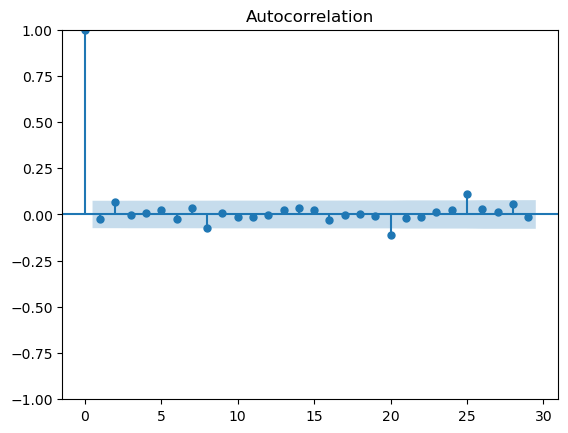

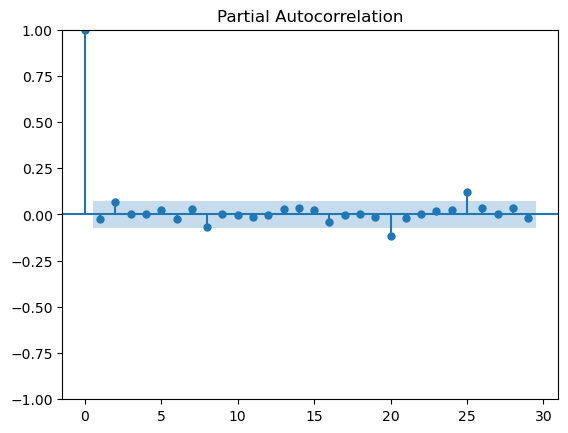

In [68]:
# ACF and PACF plots

plot_acf(data_cleaned['log_close_diff'])
plot_pacf(data_cleaned['log_close_diff'])
plt.show()

Autocorrelation Function (ACF):

The ACF drops sharply after lag 0, and the autocorrelations of subsequent lags oscillate around zero without being significant. More importantly, there is no significant decay in the autocorrelations either.
Thus, we can conclude that there is no marked autocorrelation in the data after the first lag.

Partial Autocorrelation Function (PACF):

The PACF also shows a sharp cutoff after lag 0, with non-significant values for the other lags.

It seems that we are dealing with an ARMA(0,0), meaning a model with no Autoregressive (AR) part and no Moving Average (MA) part. There are no significant autoregressive (AR) or moving average (MA) terms. Thus, the ACF and PACF plots suggest that the data follows white noise.

The appropriate model seems to be an ARMA(0,0).

Having concluded an ARMA(0,0) model, a white noise process, we need to check the whiteness of the residuals.

- III.1.c Whiteness of residuals

Characteristics of white noise:

- No significant autocorrelation in the residuals,
- The residuals follow a normal distribution.

To test the autocorrelation of the residuals, we perform the Ljung-Box test.

To check if they follow a normal distribution, we will plot a Q-plot.

In [80]:
# Ljung Box test
ljung_box_results = acorr_ljungbox(data_cleaned['log_close_diff'].dropna(), lags=[10], return_df=True)
ljung_box_results

,lb_stat,lb_pvalue
10,9.382492,0.496229


The null hypothesis of the Ljung-Box test is that the residuals are white noise (no autocorrelation of the residuals). Since the p-value is very large, we cannot reject the null hypothesis. Therefore, we are indeed dealing with uncorrelated residuals.

In [81]:
# Distribution of residuals

# We use a Q-plot.
# We compare the quantiles of the residuals vs. the quantiles of a normal distribution.
# The closer the residuals are to the diagonal line, the more the distribution of the residuals is normal.

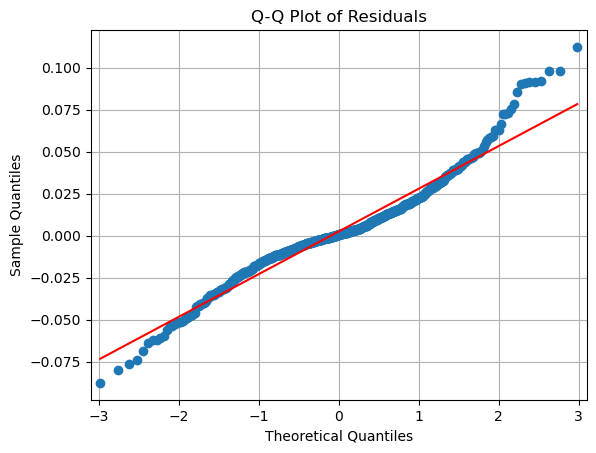

In [82]:
sm.qqplot(data_cleaned['log_close_diff'], line='s')
plt.title('Q-Q Plot of Residuals')
plt.grid()
plt.show()

Clearly, the distribution of the residuals is almost normal. We also saw that, according to the Ljung-Box test, there is no autocorrelation in the residuals. We can conclude that the residuals are white noise.

From there, we know that using an ARMA will not be much useful: if the data is truly white noise, it doesn't make sense to use ARMA for prediction because there is no predictable structure in the series to model. You would be better off using simpler approaches, such as assuming the future values will be similar to the mean of the series, or considering models that are designed for random data.

We still make the prediction with ARMA(0,0) to confirm that it is not a suitable model for our financial series, and in the next subsections, we use different methods that are more adapted to financial data.

In [ ]:
Prediction

In [83]:
# We need to use datetime format for the time variable 
# so we revert to the cleaned data, before formatting the time variable 

data_bis = df.dropna(subset=['log_close_diff', 'timestamp'])

# timestamp as a datetime type and set as index
data_bis['timestamp'] = pd.to_datetime(data_bis['timestamp'], errors='coerce', utc=True)  # Explicit datetime conversion
data_bis.set_index('timestamp', inplace=True)

# set frequency (daily in this case)
data_bis = data_bis.asfreq('D')

# extract log_close_diff series
series = data_bis['log_close_diff']

# sort data by timestamp
series = series.sort_index()

/tmp/ipykernel_1245/1493534382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bis['timestamp'] = pd.to_datetime(data_bis['timestamp'], errors='coerce', utc=True)  # Explicit datetime conversion


In [84]:
series

timestamp
2023-01-02 00:00:00+00:00    0.003372
2023-01-03 00:00:00+00:00    0.000139
2023-01-04 00:00:00+00:00    0.010451
2023-01-05 00:00:00+00:00   -0.001099
2023-01-06 00:00:00+00:00    0.007033
                               ...   
2024-11-26 00:00:00+00:00   -0.011297
2024-11-27 00:00:00+00:00    0.041511
2024-11-28 00:00:00+00:00   -0.002288
2024-11-29 00:00:00+00:00    0.018809
2024-11-30 00:00:00+00:00   -0.010853
Freq: D, Name: log_close_diff, Length: 699, dtype: float64

In [85]:
# Specify the start date for modeling 
start_date = '2023-11-30'

# Filter data starting from the specified date
series = series[series.index <= start_date]


In [86]:
# ARIMA model parameters
p = 0
d = 0
q = 0

# Fit ARIMA model with the specified order
model = ARIMA(series, order=(p, d, q), enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit()

In [87]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         log_close_diff   No. Observations:                  333
Model:                          ARIMA   Log Likelihood                 783.849
Date:                Sun, 29 Dec 2024   AIC                          -1563.698
Time:                        17:36:10   BIC                          -1556.088
Sample:                    01-02-2023   HQIC                         -1560.663
                         - 11-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.843      0.065      -0.000       0.005
sigma2         0.0005   2.64e-05     19.726      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.04   Jarque-

P values are significant at a 10% level, so we proceed to look at the forecast using ARMA(0,0)

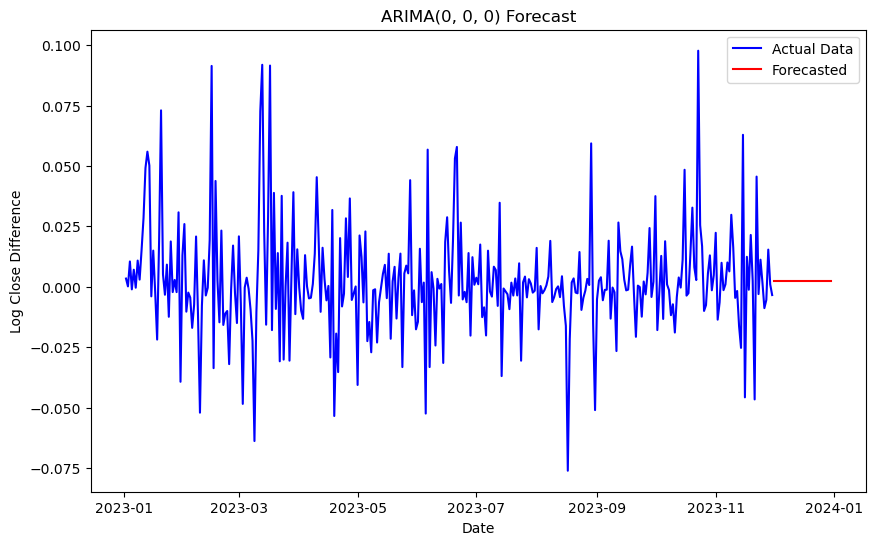

In [88]:
forecast_steps = 30  # Forecast for the next 30 days
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(series.index, series, label='Actual Data', color='blue')
plt.plot(forecast_index, forecast, label='Forecasted', color='red')
plt.title("ARIMA(0, 0, 0) Forecast")
plt.xlabel('Date')
plt.ylabel('Log Close Difference')
plt.legend()
plt.show()

As expected, when the log-differenced data behaves like white noise, it is not surprising that the forecasts of an ARIMA (or ARMA) model are close to zero or flat. This typically happens when the time series does not exhibit clear trends, cycles, or significant autocorrelations.

White noise refers to a sequence of random variables with no identifiable structure, characterized by the absence of correlation, a mean close to zero, and constant variance. When a log difference is applied to a time series, it removes any exponential growth or long-term trends, leaving only short-term variations (returns). If these variations are random (white noise), the model will struggle to identify any structures or patterns to predict.

ARIMA (or ARMA) models are designed to capture autocorrelations and trends in the data. However, if the data is white noise, uncorrelated, and random, the model will not be able to identify significant patterns, resulting in forecasts close to the mean, which, in the case of log-differenced data, could be close to zero.

Now we proceed onto the next model of choice to predict closing prices.

## **III.2  Simple Linear Regression** 

Now we use a simple linear regression. We predict prices of the period t+1 with the price of period t. This is obviously a naive model: as we see in the raw data above, the series is increasing. So we will be modelling an ever-increasing price, which is not very realistic (again, in the raw data, we see some plateaus or dips at times).

In [90]:
# Setting up parameters for a prediction model. Here, the goal is to predict the closing price 60 days in the future using the closing 
#price as the regressor.

prediction_time = 60 # We want to predict the close price 60 days Later 
regressor = ['close'] # We choose One regressor which is the colse price itself
price, target  = preprocess_for_regression(scaled_data, regressor, prediction_time) # Data Processing for the model

- Let’s perform regression analysis and visualize the results.

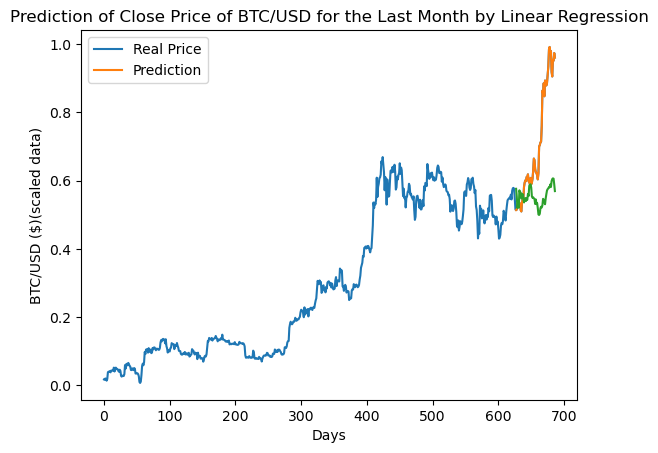

In [120]:
# Performing linear regression on the data.
regression_matrix, future_price, simple_r2 = apply_linreg(scaled_data, prediction_time, price, target, regressor)
# Plotting the model's performance on a graph.
plot_model_predictions(regression_matrix, scaled_data)

- We zoom in for better visibility.

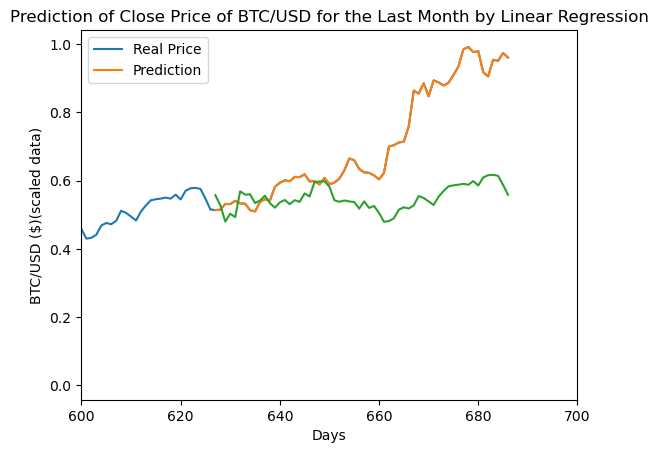

In [92]:
plot_model_predictions(regression_matrix, scaled_data, zoom_range = [600, 700])

- We calculate the R² indicator to assess the model's accuracy and relevance.

In [93]:
# Showing the R-squared value for the simple linear regression model.
simple_r2

0.7482903438050181

- The predicted values follow the general trend of the real prices but show noticeable deviations.  

- The R² value indicates a moderate fit, suggesting the model captures some but not all price dynamics.  

- The simplicity of the linear regression may limit its ability to fully capture the complexity of price movements. 
 
- Using additional variables or more sophisticated models could enhance prediction accuracy.

Visualization of predictions for the next 60 days, representing the beginning of 2025.

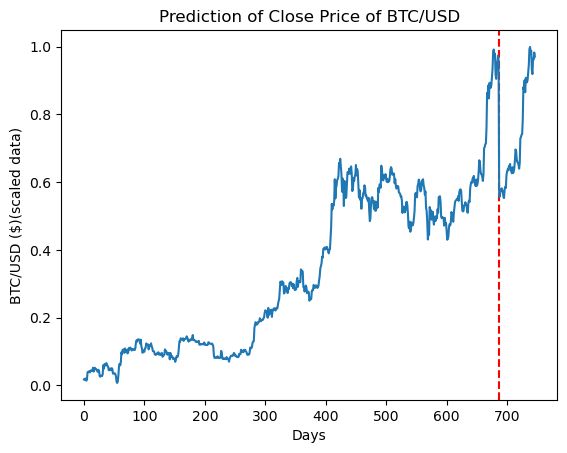

In [94]:
# Plotting the model's future price predictions.
plot_future_predictions(scaled_data, future_price)

The chart predicts a sharp rise in BTC/USD after day 700 but shows a significant dip right after the prediction starts, highlighting potential instability or overfitting in the linear regression model.

## **III.3  Multiple Linear Regression** 

Now, we add more complexity onto the previous model by adding more variables.

- Performing variable selection for multiple linear regression using the correlation matrix. We select variables that are relevant for predicting the closing price.

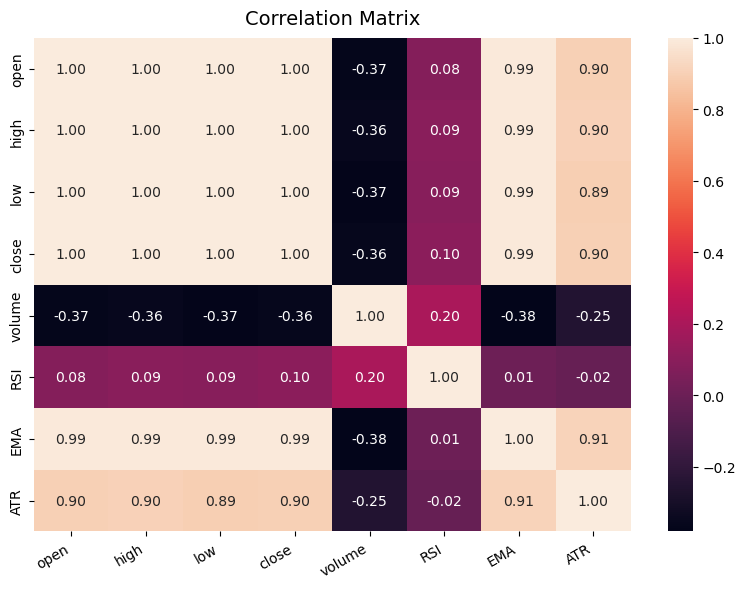

In [109]:
# Correlation matrix
corr_matrix = final_data.drop('timestamp', axis=1).corr()

# Heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,                # show coefficients
    fmt=".2f",                 # limit to 2 decimal places
)

# plot
plt.title("Correlation Matrix", fontsize=14, pad=10)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [110]:
# Identifying feature correlations with the 'close' column using the correlation matrix.
corr_matrix['close']

open      0.997519
high      0.999201
low       0.998730
close     1.000000
volume   -0.363224
RSI       0.102029
EMA       0.992670
ATR       0.899034
Name: close, dtype: float64

The Close Price appears to have a relatively strong correlation with the EMA and ATR indicators, making them suitable additions to the regression model.

Also, in multiple linear regression, using predictors that are highly correlated with the dependent variable (too close to 1) can lead to overfitting, where the model becomes too tailored to the training data and loses its ability to generalize to new data. Additionally, such predictors may not provide new or independent information, reducing the model's interpretability. 

In [98]:
# Adding 'close,' 'ATR,' and 'EMA' as key features for preprocessing the data.
regressor = ['close', 'ATR', 'EMA']
price, target  = preprocess_for_regression(scaled_data, regressor, prediction_time) 

**Apply Multiple Linear Regression**

In [99]:

regression_matrix, future_price, mult_r2 = apply_linreg(scaled_data, prediction_time, price, target, regressor)

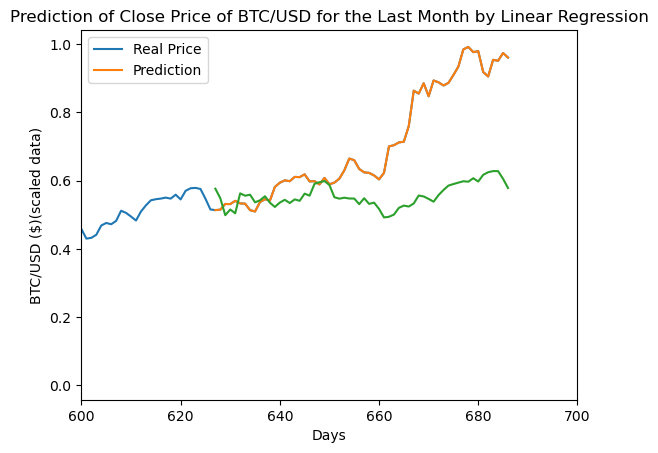

In [100]:
# Plotting the linear regression model's performance.
plot_model_predictions(regression_matrix, scaled_data, zoom_range=[600,700])

In [101]:
# Comparing the R-squared values of the multivariate model ('mult_r2') to those of the simple model ('simple_r2').
mult_r2, simple_r2

(0.7145119065440796, 0.7482903438050181)

-  The model underestimates the sharp price increase post-day 660, showing limits in handling rapid changes.

- Adding variables naturally increases the R², but this doesn’t guarantee a better model, especially since the improvement here is minimal.

- **Suggestion**: Consider non-linear models and additional evaluation metrics.

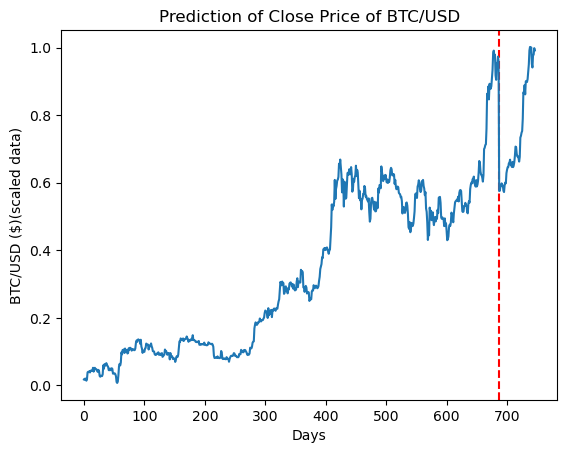

In [102]:
plot_future_predictions(scaled_data, future_price)

The model continues to exhibit a significant dip right at the start of the 2024 prediction, highlighting a recurring problem of instability or overfitting. It is, nevertheless, slightly less pronounced than in the simple linear regression.

Therefore, we use a model that prevents overfitting with regularisation parameters.

## **III.4. Support Vector Regression**

Support Vector Regression (**SVR**) is a machine learning algorithm that fits a model by finding a function within a margin of tolerance (epsilon) around the actual data points. It aims to minimize the model's complexity by maximizing the margin while ignoring small errors within this tolerance. Non-linear relationships are handled using kernel functions to map data into higher-dimensional spaces.

- First, the optimal parameters for the SVR model are determined through Cross-Validation.

In [111]:
# Defining a grid of values for 'C' and 'gamma' to optimize hyperparameters in SVM models.

param_grid = {'C': [10**i for i in range(2, 11)], 
              'gamma' : [10**(-i) for i in range(2, 11)]} # Creat a dictionnary of parameters

In [112]:
# Dividing the price and target data into training and test sets, allocating 70% of the data for training.
price_train, _, target_train, _ = train_test_split(price, target, test_size = 0.3)

# The 'cross_validation_parameter' function is utilized to identify the optimal 'C' and 'gamma' values for the model, likely employing a grid search method.
best_C, best_gamma = find_best_hyperparameters(param_grid, price_train, target_train)

In [105]:
print(f'The best values are {best_C} for C and {best_gamma} for Gamma')

The best values are 100000 for C and 0.01 for Gamma


The values C = 100,000 and gamma = 0.01 suggest a model that prioritizes fitting the data closely (with a large C) but avoids overly complex decision boundaries (with a relatively small gamma). 

These parameters could lead to overfitting, particularly due to the high C. 

- Applying and plotting of the SVR

In [107]:
# Applying a Support Vector Regression (SVR) model with the best 'C' and 'gamma' values found. 
svr_matrix, future_price, r2_svr = apply_svr_model(scaled_data, prediction_time, price, target, regressor, best_C, best_gamma)

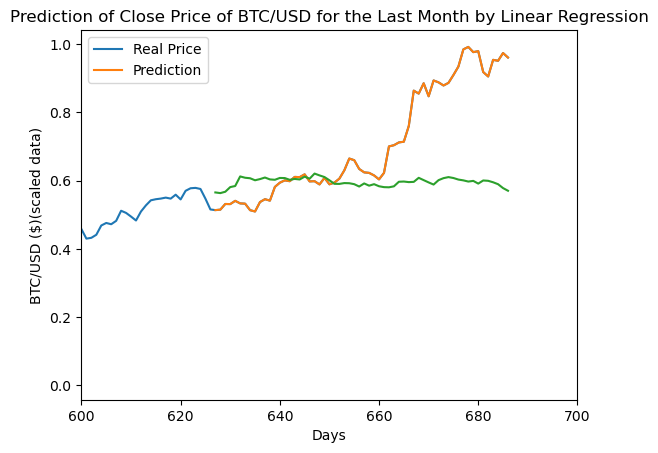

In [116]:

plot_model_predictions(svr_matrix, scaled_data, zoom_range = [600, 700])

In [31]:
# Displaying the accuracy score of the SVR model.
r2_svr

0.791312460491384

- **Model Performance:** SVR slightly outperforms the linear regression models but still struggles to capture the sharp upward trend . The improvement over linear regression is minimal, highlighting potential limitations in feature selection or model tuning.  The improvement in R² is modest and does not fully address the prediction gap.

- **Suggestion:** SVR may have limitations with certain data or dynamics, so we are going to try more flexible models.

**Prediction for early 2025**

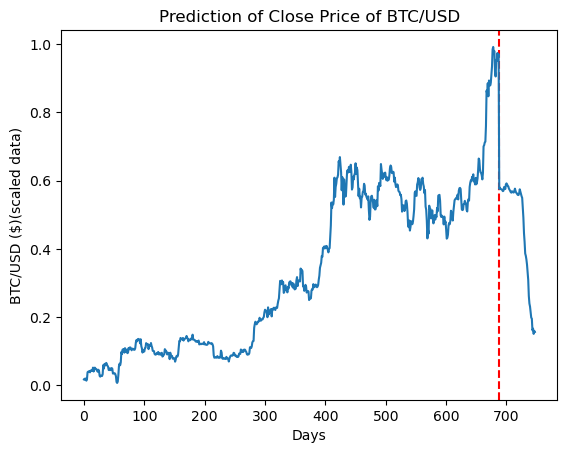

In [32]:
plot_future_predictions(scaled_data, future_price)

**Conclusion :**  The predictions for late 2024 and early 2025 are highly unreliable, showing an unrealistic sharp decline into negative values, which is inconsistent with the market context. This highlights serious limitations in the model's ability to capture and generalize future trends.

## **III.5.  Long short-term memory Model (LSTM)**

So far, we tried linear time-series model, linear regression models, and regularisation with SVM. We try using a deep learning model now.

The **LSTM** model is a type of deep learning architecture designed for time series prediction. It features memory cells that utilises a set of gates to manage information flow. The input gate, forget gate, and output gate work together to determine which information is stored, discarded, or passed on, enabling the model to handle sequential data efficiently by selectively retaining or forgetting details.

In [113]:
# Defining the sequence length for time series forecasting.
sequence_length = 20 

The neural network is trained by pairing each value with the value that occurs 20 steps later, enabling it to learn patterns for making predictions.

In [114]:
# Generating sequences from the scaled data based on the defined sequence length.
X, y = generate_sequences(scaled_data, sequence_length) # Predictions are made using a time horizon of 20 periods (e.g., 20 days or 20 hours).
# The LSTM is trained on the sequences and makes predictions through the 'lstm_model' function.
y_train, y_test, predicted_values = build_lstm_model(X, y)

Epoch 1/100


2024-12-29 18:00:18.889524: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0846
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0321 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0089 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0136 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0144 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0082 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0041 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0043 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0052 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0057 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0038 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0026 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0025 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0033 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0035 
Epoch 16/100
2/2

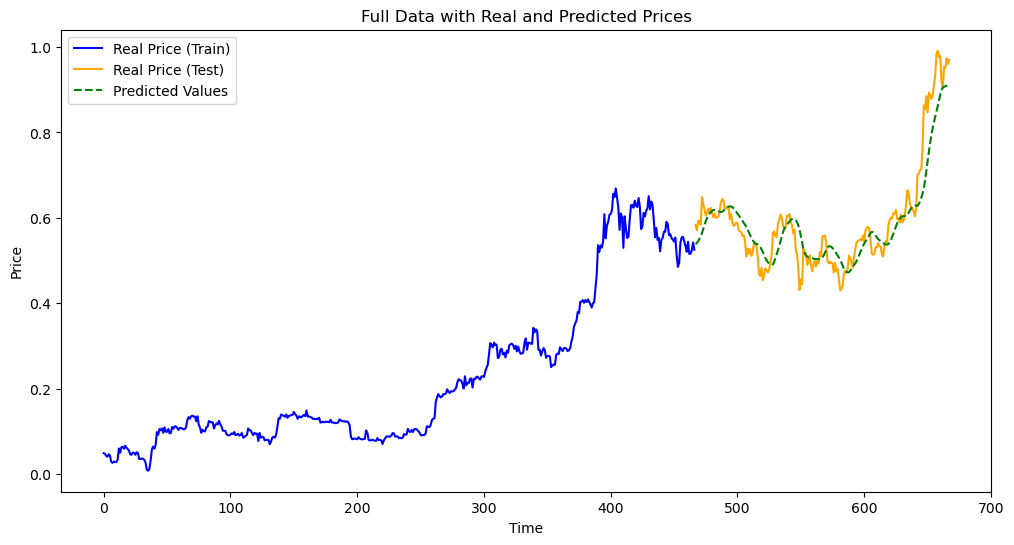

In [35]:
plot_rnn_predictions(y_train, y_test, predicted_values)

- While the prediction aligns well with the close price, it smooths out variations but retains the key peaks and drops, which are essential for a trader. The smoothing effect, though, results in the drop being delayed.

**Now, to improve our model, the next step is to use it for making hourly predictions tailored for day trading.**


- We will now move on to extracting hourly data using the Binance API.


In [48]:
# Paramètres de l'extraction
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1HOUR
start_date = '2023-01-01'
end_date = '2024-12-01'

# Extraire les données
df = fetch_binance_data_full(symbol, interval, start_date, end_date)

# Sauvegarder les données dans un fichier CSV
output_file = "BTCUSDT_hourly_2023.csv"
df.to_csv(output_file, index=False)
print(f"Données sauvegardées dans {output_file}")

# Charger les données depuis le fichier CSV
data_file = "BTCUSDT_hourly_2023.csv"
df = pd.read_csv(data_file)

# Convertir la colonne 'timestamp' en format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Vérifier les données
print(df.head())
print(df.info())

Données sauvegardées dans BTCUSDT_hourly_2023.csv
            timestamp      open      high       low     close      volume
0 2023-01-01 00:00:00  16541.77  16545.70  16508.39  16529.67  4364.83570
1 2023-01-01 01:00:00  16529.59  16556.80  16525.78  16551.47  3590.06669
2 2023-01-01 02:00:00  16551.47  16559.77  16538.14  16548.19  3318.84038
3 2023-01-01 03:00:00  16548.19  16548.19  16518.21  16533.04  4242.08050
4 2023-01-01 04:00:00  16533.04  16535.97  16511.92  16521.85  4285.00909
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16799 entries, 0 to 16798
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  16799 non-null  datetime64[ns]
 1   open       16799 non-null  float64       
 2   high       16799 non-null  float64       
 3   low        16799 non-null  float64       
 4   close      16799 non-null  float64       
 5   volume     16799 non-null  float64       
dtypes: datetime64[ns]

In [49]:
# Charger les données depuis le fichier CSV
data_file = "BTCUSDT_hourly_2023.csv"
df = pd.read_csv(data_file)

# Convertir la colonne 'timestamp' en format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Vérifier les données
print(df.head())
print(df.info())

            timestamp      open      high       low     close      volume
0 2023-01-01 00:00:00  16541.77  16545.70  16508.39  16529.67  4364.83570
1 2023-01-01 01:00:00  16529.59  16556.80  16525.78  16551.47  3590.06669
2 2023-01-01 02:00:00  16551.47  16559.77  16538.14  16548.19  3318.84038
3 2023-01-01 03:00:00  16548.19  16548.19  16518.21  16533.04  4242.08050
4 2023-01-01 04:00:00  16533.04  16535.97  16511.92  16521.85  4285.00909
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16799 entries, 0 to 16798
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  16799 non-null  datetime64[ns]
 1   open       16799 non-null  float64       
 2   high       16799 non-null  float64       
 3   low        16799 non-null  float64       
 4   close      16799 non-null  float64       
 5   volume     16799 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 787.6 KB
None


In [50]:
data_file = "BTCUSDT_hourly_2023.csv"
hour_data = pd.read_csv(data_file)

# Convertir la colonne 'timestamp' en format datetime
hour_data['timestamp'] = pd.to_datetime(hour_data['timestamp']) 
hour_btc = scaling_data(hour_data)

**We can now apply the model to this dataset, expecting improved predictions compared to the previous example due to the increased amount of data provided.**

Epoch 1/100


/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0384
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0012
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 7.8649e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 6.5322e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 5.4229e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.3909e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.5565e-04
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 4.3058e-04
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.9241e-04
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.6516e-04
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.3989e-04
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.6343e-04
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 3.5501e-04
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.3155e-04
Epoch 15/100
34/34 ━━

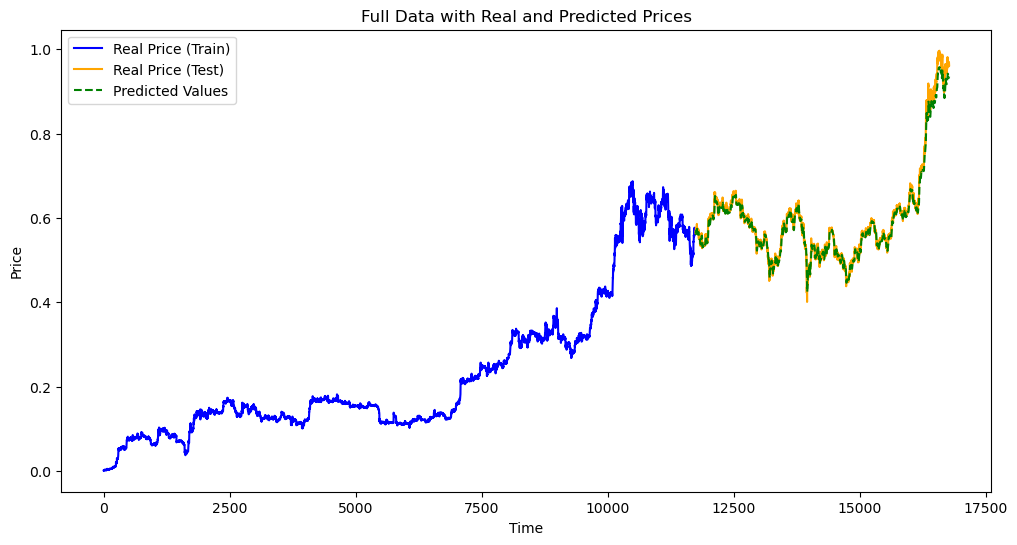

In [55]:
# Setting the sequence length for LSTM model, creating sequences from the hourly data, and applying the LSTM model to this data.
sequence_length = 20
X, y = generate_sequences(hour_btc, sequence_length) # Prediction based on 20 hours 
y_train, y_test, predicted_values = build_lstm_model(X, y)
plot_rnn_predictions(y_train, y_test, predicted_values)

- The predictions align well with the actual values, as expected ! However, with a significantly large number of data points, we observe that this function takes considerably more time to execute compared to the others.

The next phase is more complex, pushing the boundaries of what this model can do. We will implement recursive prediction with LSTM, where each predicted value is used to forecast the subsequent one. This technique is important because, in earlier examples, the model was able to accurately predict future values since it used the true value for each step. However, in this case, we lack the true values for future predictions.

In the following example, we will forecast the prices for the next 5 hours.

In [56]:
t = 5
X, y = create_sequences_recursive(hour_btc, sequence_length)
prediction = recursive_lstm_prediction(X, y, t)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0540
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0022
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0016
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0013
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0012
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0010
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 9.3446e-04
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 8.7622e-04
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 8.0124e-04
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 7.3491e-04
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 6.7498e-04
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 6.1932e-04
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 6.0100e-04
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 6.0660e-04
Epoch 15/100
48/48 ━━━━━━

In [57]:
prediction = reverse_scaling(prediction, hour_data)

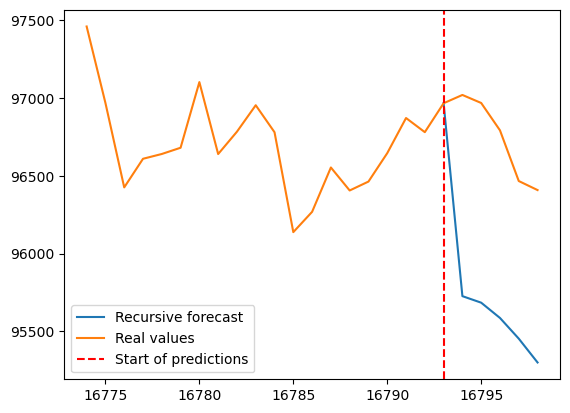

In [58]:
#Visualizing the results of the recursive prediction.

#The red dashed line at 'sequence_length' shows where the recursive prediction begins in the time series.
N = len(hour_data['close'])
x_indices = np.arange(N - sequence_length-5, N - sequence_length + len(prediction)-5)

plt.plot(x_indices[-6:], prediction[-6:], label='Recursive forecast')
plt.plot(x_indices, hour_data['close'][-25:], label='Real values')
plt.axvline(x=N-6, color='r', linestyle='--', label='Start of predictions')
plt.legend()
plt.show()


In recursive prediction, the model faces difficulties in capturing the non-linear relationships seen in historical data when applied to its own predicted values.

## **IV. GARCH model for volatility.**

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is widely used for modeling and forecasting volatility in financial time series. It captures the time-varying volatility, allowing the variance of returns to change over time based on past data. The model consists of two main components: the autoregressive (AR) part, which models the past conditional variances, and the moving average (MA) part, which models the impact of past squared errors. The parameters **p** and **q** represent the order of the AR and MA terms, respectively. Specifically, **p** refers to the number of lag observations in the variance equation, while **q** refers to the number of lag squared error terms. Additionally, the choice of error distribution is crucial in volatility modeling. In the case of a Student’s t-distribution, it accounts for heavier tails in the data, making it more suitable for financial time series that often exhibit extreme returns or outliers.

**1. Daily prediction.**

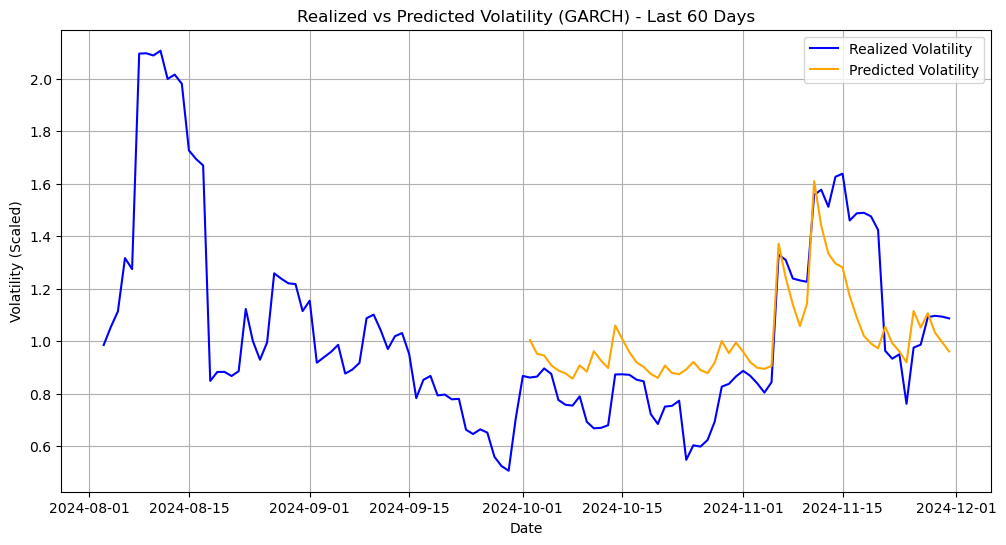

Volatility Prediction Evaluation:
Mean Squared Error (MSE): 0.0388
Root Mean Squared Error (RMSE): 0.1970
Mean Absolute Error (MAE): 0.1598
R² Score: 0.5630


In [59]:
# Load the data.
data_d = pd.read_csv('BTCUSDT_daily_2023.csv')  # Replace with your file.
data_d['timestamp'] = pd.to_datetime(data_d['timestamp'])
data_d.set_index('timestamp', inplace=True)

perform_garch_analysis(data_d,1,1)

- For the daily prediction, we implement a simple GARCH(1, 1) model with a normal distribution. We observe that the R² is not exceptionally high, but the prediction does not seem unreasonable. The trends and peaks appear to be fairly well captured. The errors are relatively low and suggest an acceptable level of error.

**Let's move on to the hourly prediction.**


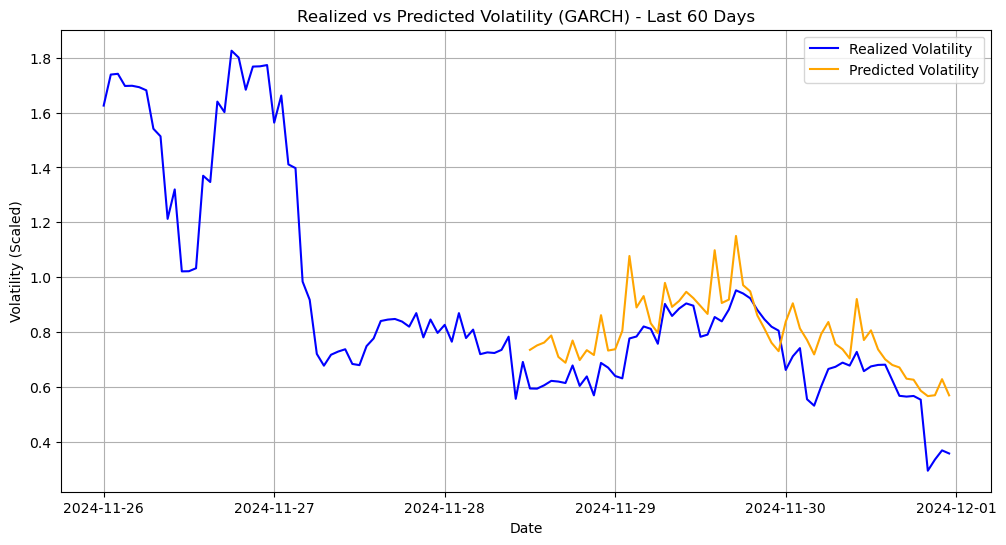

Volatility Prediction Evaluation:
Mean Squared Error (MSE): 0.0176
Root Mean Squared Error (RMSE): 0.1328
Mean Absolute Error (MAE): 0.1108
R² Score: 0.2045


In [72]:
# Load the data
data_h = pd.read_csv('BTCUSDT_hourly_2023.csv')
data_h['timestamp'] = pd.to_datetime(data_h['timestamp'])
data_h.set_index('timestamp', inplace=True)

perform_garch_analysis(data_h,2,2,'t')

Next, for the hourly prediction, the model needed improvement as the previous one yielded average results. To achieve acceptable errors and R², a more advanced model was required, specifically a GARCH(2, 2) model with a Student's t-distribution.

## **V. Dashboard**


**Open the Dashboard file and run the Streamlit module by following the instructions in the terminal.**